RFM评分统计摘要:
           R_Score     F_Score     M_Score    RFM_Score
count  4338.000000  4338.00000  4338.00000  4338.000000
mean      3.015445     3.00000     3.00000     9.015445
std       1.414537     1.41454     1.41454     3.591229
min       1.000000     1.00000     1.00000     3.000000
25%       2.000000     2.00000     2.00000     6.000000
50%       3.000000     3.00000     3.00000     9.000000
75%       4.000000     4.00000     4.00000    12.000000
max       5.000000     5.00000     5.00000    15.000000


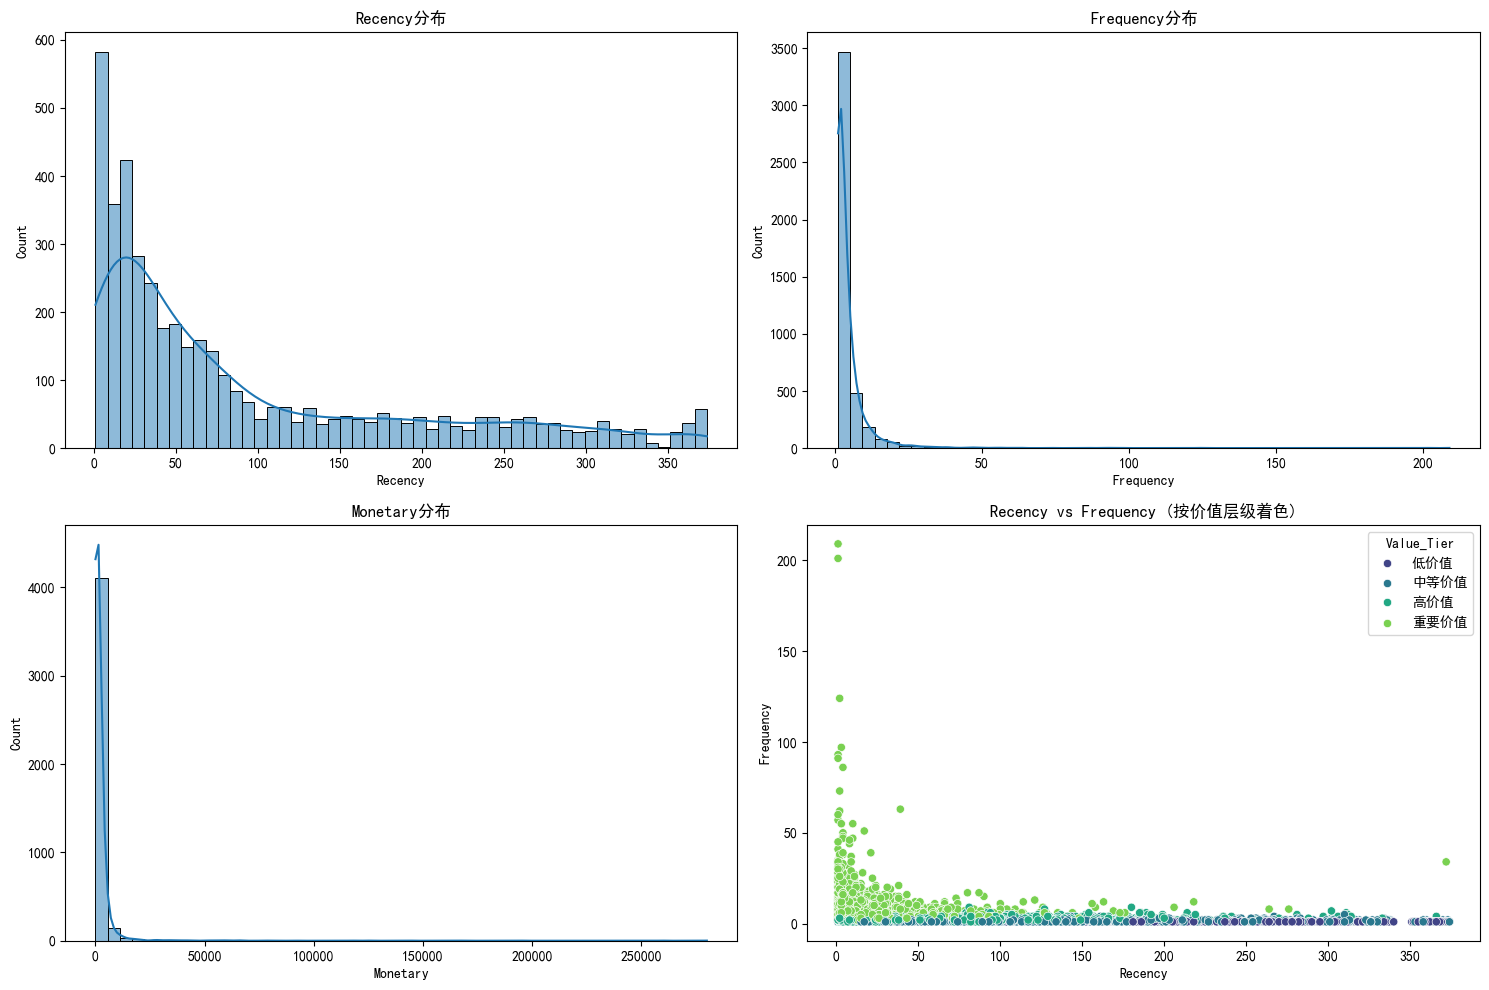

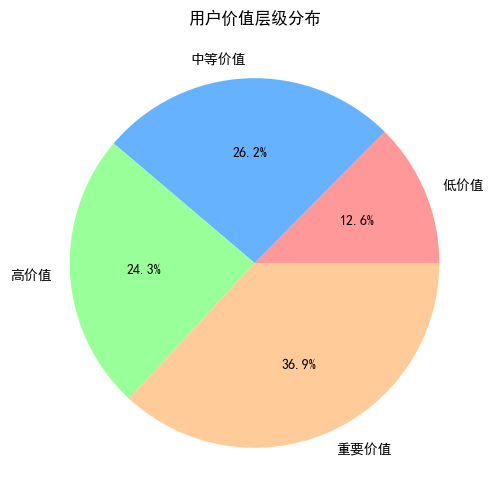

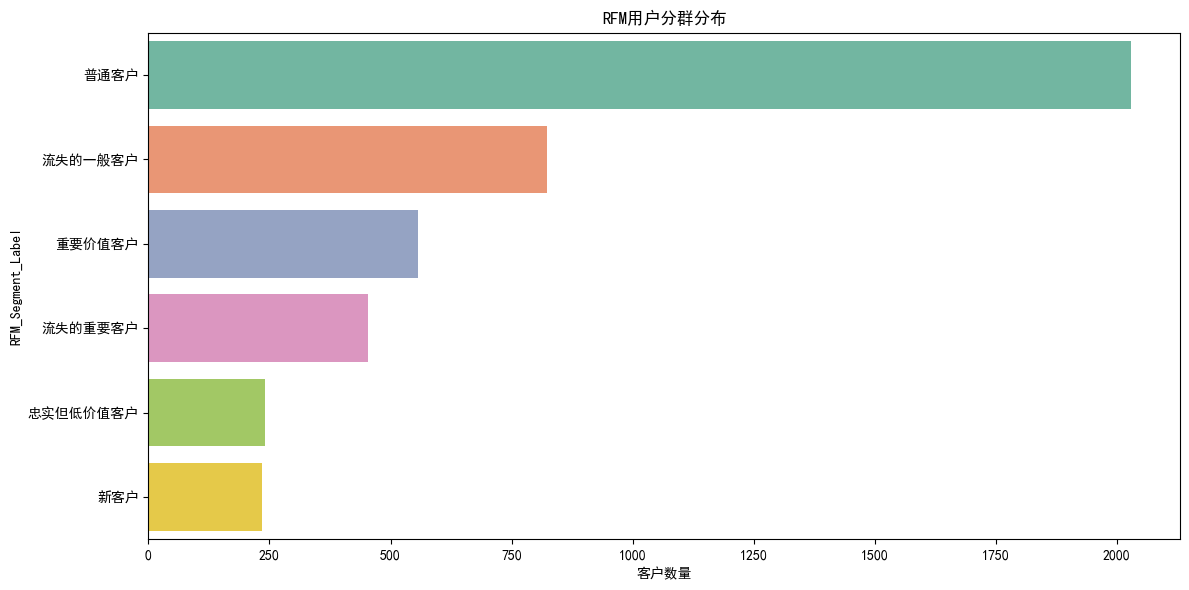

重要价值客户数量: 557
重要价值客户示例:
    CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
1        12347        2          7   4310.00        5        5        5   
15       12362        3         10   5226.23        5        5        5   
17       12364        8          4   1313.10        5        4        4   
30       12381        5          5   1845.31        5        4        4   
56       12417        3          9   3649.10        5        5        5   

    RFM_Score RFM_Segment Value_Tier RFM_Segment_Label  
1          15         555       重要价值            重要价值客户  
15         15         555       重要价值            重要价值客户  
17         13         544       重要价值            重要价值客户  
30         13         544       重要价值            重要价值客户  
56         15         555       重要价值            重要价值客户  

===== RFM分析报告摘要 =====
分析日期: 2011-12-10
分析客户总数: 4338

价值层级分布:
Value_Tier
重要价值    1600
中等价值    1138
高价值     1055
低价值      545
Name: count, dtype: int64

RFM分群分布:
RFM_Segment_Label
普通客户

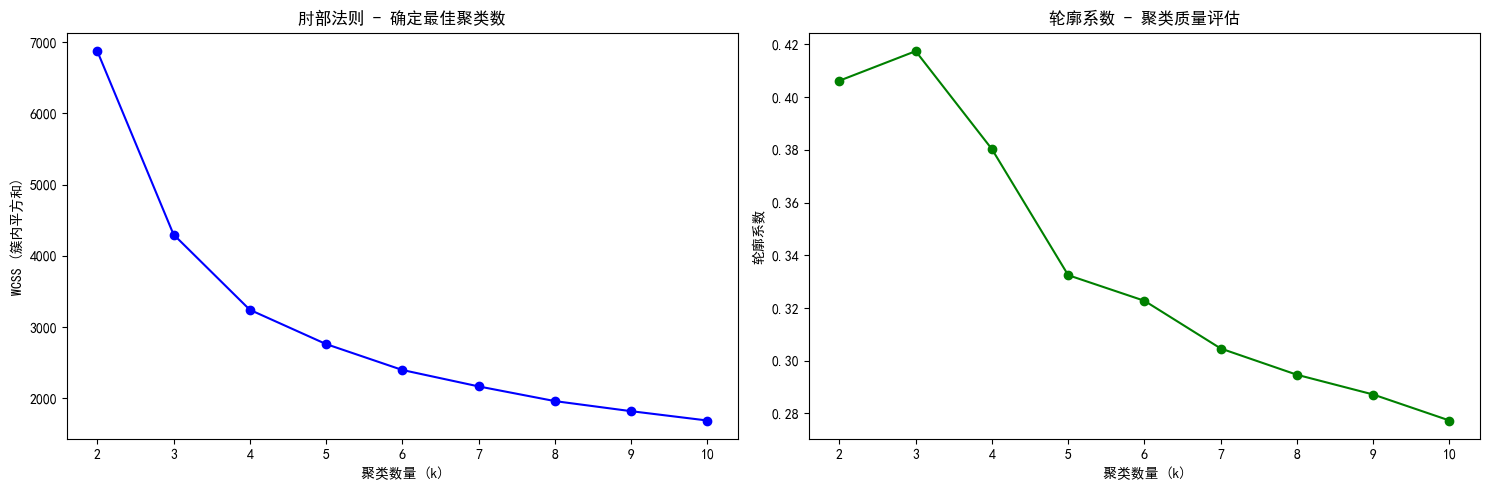

最佳聚类数: 3 (轮廓系数: 0.417)

聚类摘要统计:
                     Recency  Frequency     Monetary  Count  Percentage
Cluster                                                                
Cluster 2 - 中高价值   30.100529   9.829932  5494.341156   1323   30.497925
Cluster 1 - 高价值    54.857073   2.046169   615.235984   2036   46.934071
Cluster 3 - 中等价值  255.271706   1.390194   398.134924    979   22.568004


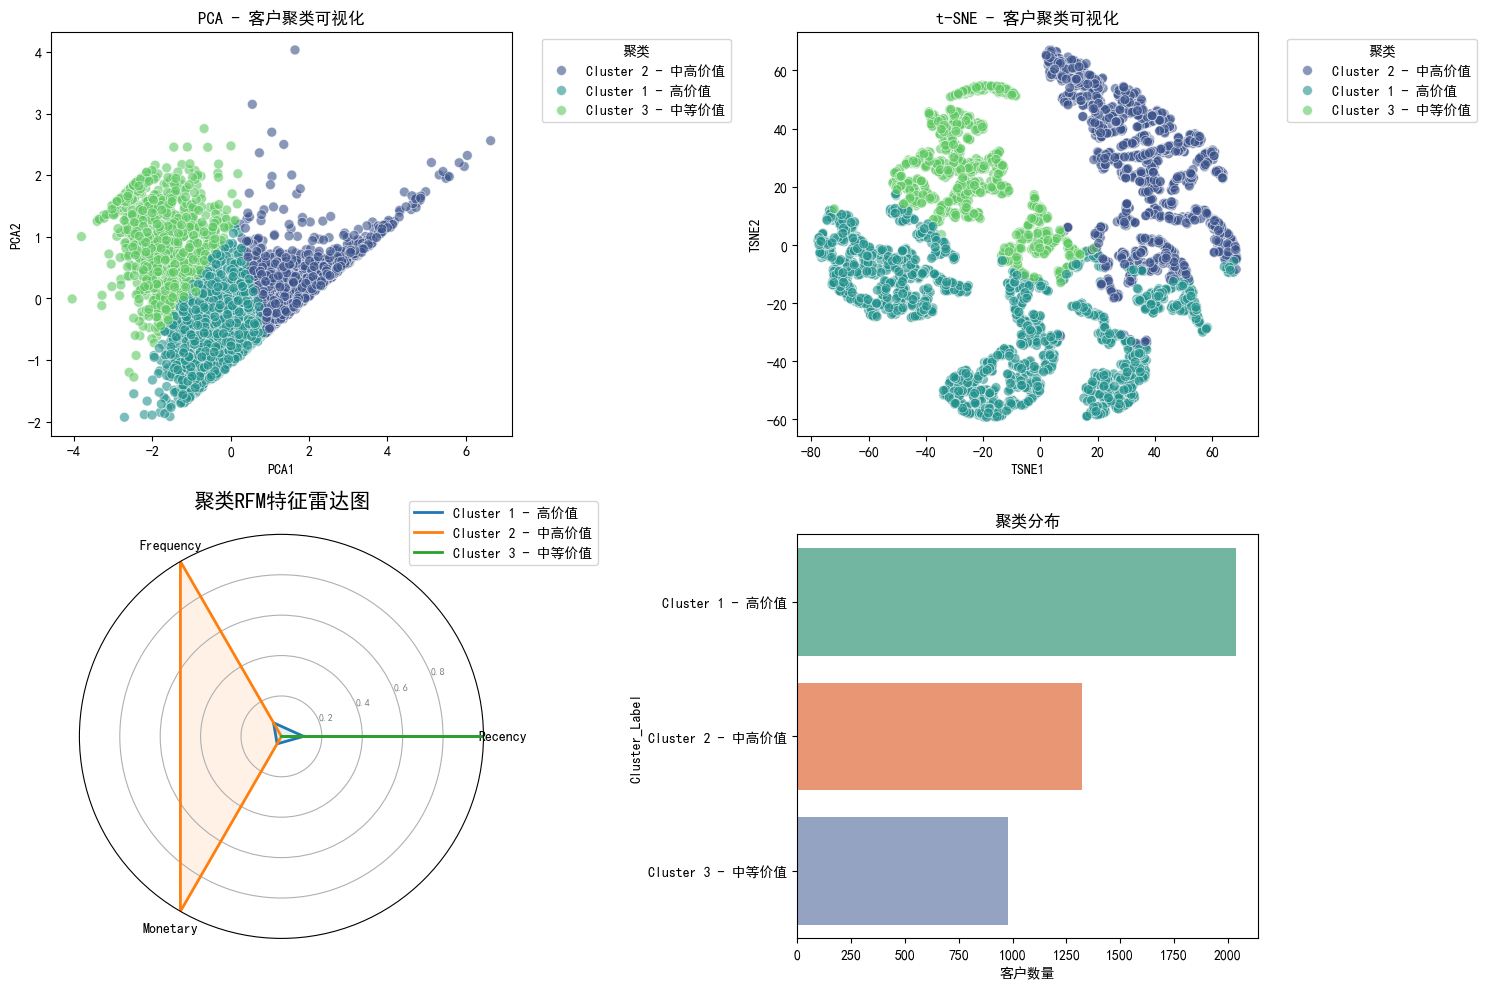


===== 聚类分析报告 =====
总客户数: 4338
聚类数量: 3
最佳轮廓系数: 0.417

聚类: Cluster 1 - 高价值
客户数量: 2036 (46.9%)
平均最近购买天数: 54.9
平均购买频率: 2.0
平均购买金额: 615.2
典型客户ID: 12596 (Recency=51, Freq=2, Monetary=618.27)

聚类: Cluster 2 - 中高价值
客户数量: 1323 (30.5%)
平均最近购买天数: 30.1
平均购买频率: 9.8
平均购买金额: 5494.3
典型客户ID: 16609 (Recency=15, Freq=7, Monetary=5493.46)

聚类: Cluster 3 - 中等价值
客户数量: 979 (22.6%)
平均最近购买天数: 255.3
平均购买频率: 1.4
平均购买金额: 398.1
典型客户ID: 12792 (Recency=257, Freq=1, Monetary=400.54)


C:\Users\李智勇\AppData\Local\Temp\ipykernel_28232\3437408798.py:444: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.74it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings


# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
mpl.rcParams['font.family'] = 'sans-serif'

df=pd.read_csv('OnlineRetail.csv',encoding='latin1')#encoding='latin1',常见于包含英镑符号的文件 
def preprocess_data(df):
    # 移除取消的订单（以"C"开头的订单号）
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
    
    # 删除缺失的客户ID
    df = df.dropna(subset=['CustomerID'])
    
    # 转换为正确的数据类型
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['CustomerID'] = df['CustomerID'].astype(int)
    
    # 计算每笔交易的总金额
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    
    # 移除异常值（负数量和负价格）
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
    
    return df

df = preprocess_data(df)

# 设置分析时间点（最近一次交易日期的第二天）
analysis_date = df['InvoiceDate'].max() + timedelta(days=1)

# 计算RFM值
def calculate_rfm(df, analysis_date):
    # 按客户分组计算RFM指标
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # 最近一次交易距今的天数
        'InvoiceNo': 'nunique',  # 交易次数
        'TotalPrice': 'sum'      # 总交易金额
    }).reset_index()
    
    # 重命名列
    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    
    return rfm

rfm_df = calculate_rfm(df, analysis_date)

# 创建RFM评分
def create_rfm_scores(rfm_df):
    """简化版RFM评分，避免复杂分箱逻辑"""
    
    # 1. Recency评分 - 直接使用分位数
    rfm_df['R_Score'] = 6 - pd.qcut(
        rfm_df['Recency'], 
        5, 
        labels=[1, 2, 3, 4, 5],
        duplicates='drop'
    ).fillna(1).astype(int)  # 反转评分
    
    # 2. Frequency评分 - 使用排名
    rfm_df['F_Score'] = pd.qcut(
        rfm_df['Frequency'].rank(method='first'), 
        5, 
        labels=[1, 2, 3, 4, 5],
        duplicates='drop'
    ).fillna(1).astype(int)
    
    # 3. Monetary评分 - 使用排名
    rfm_df['M_Score'] = pd.qcut(
        rfm_df['Monetary'].rank(method='first'), 
        5, 
        labels=[1, 2, 3, 4, 5],
        duplicates='drop'
    ).fillna(1).astype(int)
    
    # 计算RFM总分
    rfm_df['RFM_Score'] = rfm_df['R_Score'] + rfm_df['F_Score'] + rfm_df['M_Score']
    
    # 创建RFM字符串
    rfm_df['RFM_Segment'] = (
        rfm_df['R_Score'].astype(str) + 
        rfm_df['F_Score'].astype(str) + 
        rfm_df['M_Score'].astype(str)
    )
    
    # 添加诊断
    print("RFM评分统计摘要:")
    print(rfm_df[['R_Score', 'F_Score', 'M_Score', 'RFM_Score']].describe())
    
    return rfm_df
rfm_df = create_rfm_scores(rfm_df)

# 定义用户价值层级
def assign_value_tier(rfm_df):
    # 基于RFM总分定义层级
    tier_labels = ['低价值', '中等价值', '高价值', '重要价值']
    rfm_df['Value_Tier'] = pd.cut(rfm_df['RFM_Score'], 
                                 bins=[0, 4, 7, 10, 15],
                                 labels=tier_labels)
    
    # 基于RFM细分策略定义经典用户分群
    conditions = [
        (rfm_df['RFM_Segment'].str.startswith('5') & (rfm_df['F_Score'] >= 4) & (rfm_df['M_Score'] >= 4)),  # 重要价值客户
        (rfm_df['R_Score'] >= 4) & (rfm_df['F_Score'] < 3) & (rfm_df['M_Score'] < 3),  # 新客户
        (rfm_df['R_Score'] < 3) & (rfm_df['F_Score'] >= 3) & (rfm_df['M_Score'] >= 3),  # 流失的重要客户
        (rfm_df['R_Score'] < 3) & (rfm_df['F_Score'] < 3) & (rfm_df['M_Score'] < 3),  # 流失的一般客户
        (rfm_df['R_Score'] >= 3) & (rfm_df['F_Score'] >= 3) & (rfm_df['M_Score'] < 3)   # 忠实但低价值客户
    ]
    
    segment_labels = ['重要价值客户', '新客户', '流失的重要客户', '流失的一般客户', '忠实但低价值客户']
    
    rfm_df['RFM_Segment_Label'] = np.select(conditions, segment_labels, default='普通客户')
    
    return rfm_df

rfm_df = assign_value_tier(rfm_df)

# 可视化分析
def visualize_rfm(rfm_df):
    plt.figure(figsize=(15, 10))
    
    # RFM分布图
    plt.subplot(2, 2, 1)
    sns.histplot(rfm_df['Recency'], bins=50, kde=True)
    plt.title('Recency分布')
    
    plt.subplot(2, 2, 2)
    sns.histplot(rfm_df['Frequency'], bins=50, kde=True)
    plt.title('Frequency分布')
    
    plt.subplot(2, 2, 3)
    sns.histplot(rfm_df['Monetary'], bins=50, kde=True)
    plt.title('Monetary分布')
    
    plt.subplot(2, 2, 4)
    sns.scatterplot(x='Recency', y='Frequency', hue='Value_Tier', data=rfm_df, palette='viridis')
    plt.title('Recency vs Frequency (按价值层级着色)')
    
    plt.tight_layout()
    plt.savefig('RFM_Distributions.png', dpi=300)
    plt.show()
    
    # 用户价值层级分布
    plt.figure(figsize=(10, 6))
    value_counts = rfm_df['Value_Tier'].value_counts().sort_index()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', 
            colors=['#FF9999','#66B2FF','#99FF99','#FFCC99'])
    plt.title('用户价值层级分布')
    plt.savefig('Value_Tier_Distribution.png', dpi=300)
    plt.show()
    
    # RFM分群分布
    plt.figure(figsize=(12, 6))
    segment_counts = rfm_df['RFM_Segment_Label'].value_counts()
    sns.barplot(x=segment_counts.values, y=segment_counts.index, hue=segment_counts.index, 
            palette='Set2', dodge=False, legend=False)
    plt.title('RFM用户分群分布')
    plt.xlabel('客户数量')
    plt.tight_layout()
    plt.savefig('RFM_Segment_Distribution.png', dpi=300)
    plt.show()

visualize_rfm(rfm_df)

# 保存结果
rfm_df.to_csv('RFM_Analysis_Results.csv', index=False)

# 输出重要价值客户
top_customers = rfm_df[rfm_df['RFM_Segment_Label'] == '重要价值客户']
print(f"重要价值客户数量: {len(top_customers)}")
print("重要价值客户示例:")
print(top_customers.head())

# 分析报告摘要
def generate_summary_report(rfm_df):
    print("\n===== RFM分析报告摘要 =====")
    print(f"分析日期: {analysis_date.strftime('%Y-%m-%d')}")
    print(f"分析客户总数: {len(rfm_df)}")
    print("\n价值层级分布:")
    print(rfm_df['Value_Tier'].value_counts())
    
    print("\nRFM分群分布:")
    print(rfm_df['RFM_Segment_Label'].value_counts())
    
    # 计算各分群的平均RFM值
    segment_analysis = rfm_df.groupby('RFM_Segment_Label').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'CustomerID': 'count'
    }).rename(columns={'CustomerID': 'Count'})
    
    segment_analysis['Percentage'] = segment_analysis['Count'] / segment_analysis['Count'].sum() * 100
    segment_analysis = segment_analysis.sort_values('Monetary', ascending=False)
    
    print("\n各分群RFM指标平均值:")
    print(segment_analysis)
    
    return segment_analysis

segment_analysis = generate_summary_report(rfm_df)

# 保存分群分析结果
segment_analysis.to_csv('RFM_Segment_Analysis.csv')

def perform_kmeans_clustering(rfm_df):
    """
    使用K-Means聚类对用户进行分群
    """
    # 1. 准备数据 - 只使用RFM特征
    rfm_features = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()
    
    # 2. 数据转换 - 处理偏斜分布
    # 对Frequency和Monetary进行对数转换
    rfm_features['Frequency_log'] = np.log1p(rfm_features['Frequency'])
    rfm_features['Monetary_log'] = np.log1p(rfm_features['Monetary'])
    
    # 3. 数据标准化
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_features[['Recency', 'Frequency_log', 'Monetary_log']])
    rfm_scaled_df = pd.DataFrame(rfm_scaled, 
                                 columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'],
                                 index=rfm_features.index)
    
    # 4. 确定最佳聚类数
    wcss = []  # Within-Cluster-Sum-of-Squares
    silhouette_scores = []
    k_range = range(2, 11)  # 测试2-10个聚类
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(rfm_scaled_df)
        wcss.append(kmeans.inertia_)
        
        # 计算轮廓系数（数据量大时可能耗时）
        if len(rfm_scaled_df) > 1000:
            sample_size = min(1000, len(rfm_scaled_df))
            sample_indices = np.random.choice(rfm_scaled_df.index, sample_size, replace=False)
            sample_data = rfm_scaled_df.loc[sample_indices]
            score = silhouette_score(sample_data, kmeans.predict(sample_data))
        else:
            score = silhouette_score(rfm_scaled_df, kmeans.labels_)
        silhouette_scores.append(score)
    
    # 可视化肘部法则和轮廓系数
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_range, wcss, 'bo-')
    plt.xlabel('聚类数量 (k)')
    plt.ylabel('WCSS (簇内平方和)')
    plt.title('肘部法则 - 确定最佳聚类数')
    
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'go-')
    plt.xlabel('聚类数量 (k)')
    plt.ylabel('轮廓系数')
    plt.title('轮廓系数 - 聚类质量评估')
    
    plt.tight_layout()
    plt.savefig('KMeans_Elbow_Silhouette.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 选择最佳k值 - 轮廓系数最高且k值合理
    best_k = np.argmax(silhouette_scores) + 2  # +2因为k_range从2开始
    print(f"最佳聚类数: {best_k} (轮廓系数: {silhouette_scores[best_k-2]:.3f})")
    
    # 5. 使用最佳k值进行聚类
    kmeans = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=20)
    clusters = kmeans.fit_predict(rfm_scaled_df)
    rfm_df['Cluster'] = clusters
    
    # 6. 分析聚类结果
    # 计算每个聚类的RFM平均值
    cluster_summary = rfm_df.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'CustomerID': 'count'
    }).rename(columns={'CustomerID': 'Count'})
    
    cluster_summary['Percentage'] = cluster_summary['Count'] / cluster_summary['Count'].sum() * 100
    
    # 排序聚类（按价值从高到低）
    cluster_summary = cluster_summary.sort_values('Monetary', ascending=False)
    
    # 重命名聚类（按价值排序）
    cluster_names = {
        i: f'Cluster {i+1} - {value_level}' 
        for i, value_level in enumerate([
            '高价值', '中高价值', '中等价值', '中低价值', '低价值'
        ][:best_k])
    }
    
    # 如果聚类数超过5个，使用通用命名
    if best_k > 5:
        cluster_names = {i: f'聚类{i+1}' for i in range(best_k)}
    
    rfm_df['Cluster_Label'] = rfm_df['Cluster'].map(cluster_names)
    
    # 重新排序聚类标签
    cluster_summary.index = cluster_summary.index.map(lambda x: cluster_names.get(x, f'聚类{x}'))
    cluster_summary = cluster_summary.sort_values('Monetary', ascending=False)
    
    print("\n聚类摘要统计:")
    print(cluster_summary)
    
    # 7. 可视化聚类结果
    # 使用PCA降维进行可视化
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(rfm_scaled_df)
    rfm_df['PCA1'] = pca_result[:, 0]
    rfm_df['PCA2'] = pca_result[:, 1]
    
    # 使用t-SNE降维（可选，数据量大时可能耗时）
    if len(rfm_scaled_df) < 5000:
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        tsne_result = tsne.fit_transform(rfm_scaled_df)
        rfm_df['TSNE1'] = tsne_result[:, 0]
        rfm_df['TSNE2'] = tsne_result[:, 1]
    
    # 绘制聚类结果
    plt.figure(figsize=(15, 10))
    
    # PCA可视化
    plt.subplot(2, 2, 1)
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_Label', data=rfm_df, 
                   palette='viridis', alpha=0.6, s=50)
    plt.title('PCA - 客户聚类可视化')
    plt.legend(title='聚类', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 3D可视化（可选）
    if len(rfm_scaled_df) < 5000:
        plt.subplot(2, 2, 2)
        sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster_Label', data=rfm_df, 
                       palette='viridis', alpha=0.6, s=50)
        plt.title('t-SNE - 客户聚类可视化')
        plt.legend(title='聚类', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 每个聚类的RFM雷达图
    # 准备数据
    cluster_means = rfm_df.groupby('Cluster_Label')[['Recency', 'Frequency', 'Monetary']].mean()
    
    # 标准化每个特征（0-1范围）
    cluster_means_scaled = cluster_means.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    # 设置雷达图参数
    categories = ['Recency', 'Frequency', 'Monetary']
    N = len(categories)
    
    # 计算每个角度的值
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # 闭合雷达图
    
    # 创建雷达图
    plt.subplot(2, 2, 3, polar=True)
    
    for idx, row in cluster_means_scaled.iterrows():
        values = row.values.tolist()
        values += values[:1]  # 闭合雷达图
        plt.plot(angles, values, linewidth=2, linestyle='solid', label=idx)
        plt.fill(angles, values, alpha=0.1)
    
    # 添加标签
    plt.xticks(angles[:-1], categories)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
    plt.ylim(0, 1)
    plt.title('聚类RFM特征雷达图', size=15, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    # 聚类分布条形图
    plt.subplot(2, 2, 4)
    cluster_counts = rfm_df['Cluster_Label'].value_counts()
    sns.barplot(x=cluster_counts.values, y=cluster_counts.index, 
                hue=cluster_counts.index, palette='Set2', dodge=False, legend=False)
    plt.title('聚类分布')
    plt.xlabel('客户数量')
    
    plt.tight_layout()
    plt.savefig('KMeans_Clustering_Results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 8. 保存聚类结果
    rfm_df.to_csv('RFM_Clusters.csv', index=False)
    cluster_summary.to_csv('Cluster_Summary.csv')
    
    # 9. 聚类分析报告
    print("\n===== 聚类分析报告 =====")
    print(f"总客户数: {len(rfm_df)}")
    print(f"聚类数量: {best_k}")
    print(f"最佳轮廓系数: {silhouette_scores[best_k-2]:.3f}")
    
    # 描述每个聚类
    for cluster_id, cluster_data in rfm_df.groupby('Cluster_Label'):
        print(f"\n聚类: {cluster_id}")
        print(f"客户数量: {len(cluster_data)} ({len(cluster_data)/len(rfm_df)*100:.1f}%)")
        print(f"平均最近购买天数: {cluster_data['Recency'].mean():.1f}")
        print(f"平均购买频率: {cluster_data['Frequency'].mean():.1f}")
        print(f"平均购买金额: {cluster_data['Monetary'].mean():.1f}")
        
        # 识别典型客户
        centroid = cluster_data[['Recency', 'Frequency', 'Monetary']].mean()
        distances = np.linalg.norm(cluster_data[['Recency', 'Frequency', 'Monetary']] - centroid, axis=1)
        typical_customer = cluster_data.iloc[distances.argmin()]
        print(f"典型客户ID: {typical_customer['CustomerID']} (Recency={typical_customer['Recency']}, Freq={typical_customer['Frequency']}, Monetary={typical_customer['Monetary']:.2f})")
    
    return rfm_df

# 加载之前保存的RFM数据
try:
    rfm_df = pd.read_csv('RFM_Analysis_Results.csv')
except:
    # 如果文件不存在，重新运行RFM分析
    # 这里需要插入之前RFM分析的代码
    print("请先运行RFM分析以生成RFM数据")
    # 退出或调用RFM分析函数
    # rfm_df = run_rfm_analysis()
    # 为演示目的，创建一个示例数据
    print("创建示例数据用于演示...")
    np.random.seed(42)
    n_customers = 1000
    rfm_df = pd.DataFrame({
        'CustomerID': range(1, n_customers+1),
        'Recency': np.random.gamma(5, 10, n_customers),
        'Frequency': np.random.poisson(3, n_customers) + 1,
        'Monetary': np.random.lognormal(3, 1, n_customers)
    })

# 执行K-Means聚类
clustered_rfm_df = perform_kmeans_clustering(rfm_df)
from pandas_profiling import ProfileReport
profile = ProfileReport(df)
profile.to_file("report.html")
